In [1]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals

In [2]:
Omega_01 = 5.0  # Ghz
Delta = -0.25
Omega_02 = 2 * Omega_01 + Delta
Lambda = 0.8

ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()

In [3]:
# drift, control, R_frame
drift = 2 * np.pi * (Omega_01 * P1 + Omega_02 * P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda * (sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01 * P1 + 2 * Omega_01 * P2)

In [4]:
y0 = Statevector([1.0, 0.0, 0.0])
dt = 0.1
area = 0.4
sigma = 5  # ns
amp = 0.04265488 # from rabi experiment
sigma = sigma / dt  # ns

duration = np.math.ceil(sigma * 5)
T = duration * dt  # ns

In [5]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
    rwa_cutoff_freq=1.5 * Omega_01,
    rwa_carrier_freqs=[Omega_01],
)

In [6]:
def make_signal(duration, amp, sigma, w, reps, waveform, dt=dt):

    with pulse.build(name="spec") as spec:
        if waveform == "g":
            pulse.play(
                pulse.Gaussian(duration=duration, amp=amp/2, sigma=sigma),
                pulse.DriveChannel(0),
                "SX"
            )
            
            [
                pulse.play(
                    pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
                    pulse.DriveChannel(0),
                    "X"
                )
                for _ in range(reps)
            ]
        elif waveform == "d":
            pulse.play(
                pulse.Drag(duration=duration, amp=amp/2, sigma=sigma, beta=2.0),
                pulse.DriveChannel(0),
                "SX"
            )

            [
                pulse.play(
                    pulse.Drag(duration=duration, amp=amp, sigma=sigma, beta=2.0),
                    pulse.DriveChannel(0),
                    "X"
                )
                for _ in range(reps)
            ]

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signals = converter.get_signals(spec)
    return signals #, spec #.draw()

In [7]:
def solve(duration, amp, sigma, omega_d, rep_range, waveform, dt=dt):
    solutions = []
    for reps in tqdm(rep_range):
        t_final = (1+reps) * T
        
        solution = hamiltonian_solver.solve(
            t_span=[0.0, t_final],
            y0=y0,
            t_eval=[t_final,],
            signals=make_signal(duration, amp, sigma, omega_d, reps, 'g', dt),
        )
        solutions.append(solution.y[0])
    return solutions

In [8]:
rep_range = range(50)

%time solutions_g = solve(duration, amp, sigma, Omega_01, rep_range,'g')
prob1_g = np.array([psi.probabilities()[1] for psi in solutions_g])

# %time solutions_d = solve(duration, amp_range, sigma, Omega_01, 'd')
# max_amp_d = np.array([sol.y[-1].probabilities() for sol in solutions_d])

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [22:54<00:00, 27.48s/it]

CPU times: user 22min 34s, sys: 22.7 s, total: 22min 56s
Wall time: 22min 54s


In [9]:
from scipy.optimize import curve_fit, minimize

fit_func = lambda n, A, B, dtheta: B + A*np.cos(n*(np.pi + dtheta) - np.pi/2)

popt, _ = curve_fit(
    fit_func,
    rep_range,
    prob1_g,
    p0=[0.505, 0.5, 0.1],
)
print(popt)

[0.48792223 0.49976148 0.02548626]


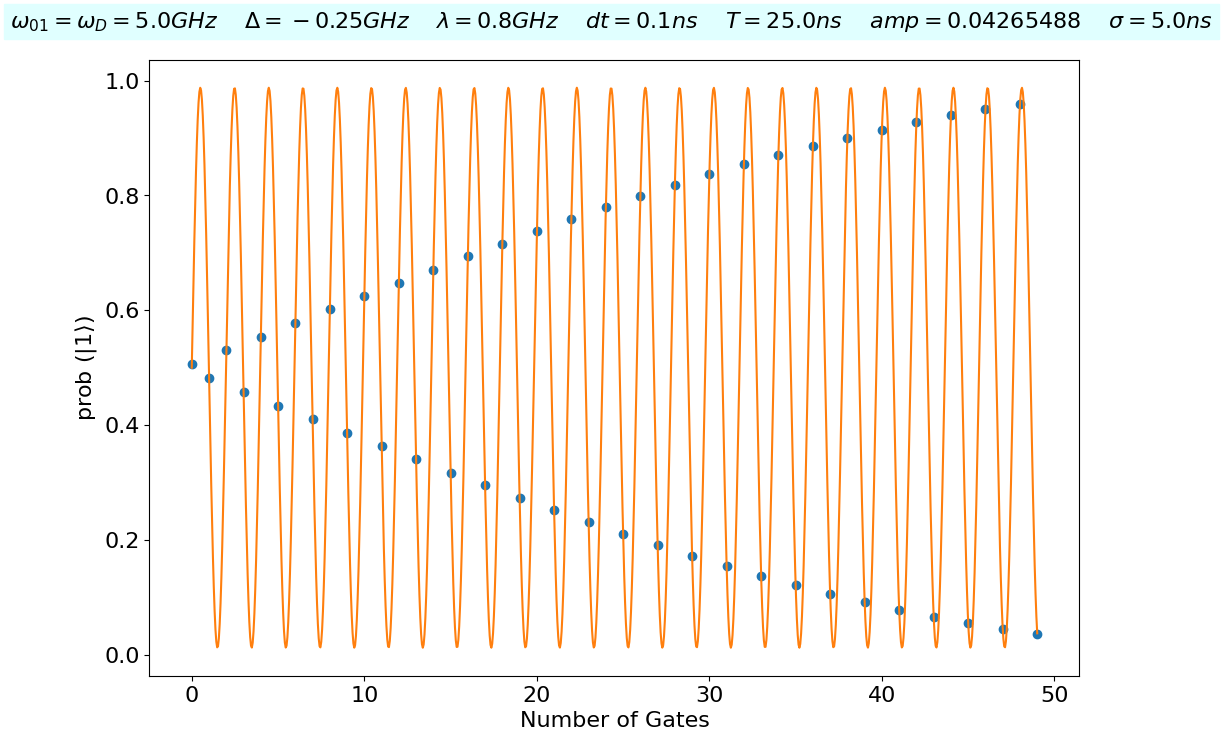

In [10]:
plt.close()
fig = plt.figure(figsize = (12,8))
plt.scatter(rep_range, [psi.probabilities()[1] for psi in solutions_g], label = "Fine Amplitude exp")
plt.plot(np.linspace(0,rep_range[-1],1000), fit_func(np.linspace(0,rep_range[-1],1000), *popt), label = "Fit", c='tab:orange')

# plt.ylim(-0.12, 1.12)
plt.xlabel("Number of Gates")
plt.ylabel(r"prob $(|1\rangle)$")

fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}} = \omega_D = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$T = {T} ns$    "
        + f"$amp = {amp}$    "
        + f"$\sigma = {sigma * dt} ns$"
    ),
    backgroundcolor="lightcyan",
    fontsize=16,
    horizontalalignment="center",
);

In [11]:
d_theta = popt[2]
scale = np.pi/(np.pi + d_theta)
new_amp = amp*scale
print(new_amp, scale)

0.042311625746310644 0.9919527553778288


In [12]:
%time solutions_g2 = solve(duration, new_amp, sigma, Omega_01, rep_range,'g')
prob1_g2 = np.array([psi.probabilities()[1] for psi in solutions_g2])

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [23:24<00:00, 28.09s/it]

CPU times: user 23min 14s, sys: 13.1 s, total: 23min 27s
Wall time: 23min 24s


In [13]:
popt2, _ = curve_fit(
    fit_func,
    rep_range,
    prob1_g2,
    p0=popt,
)
print(popt2)

[-1.95097934e+00  4.99798088e-01  2.02586530e-04]


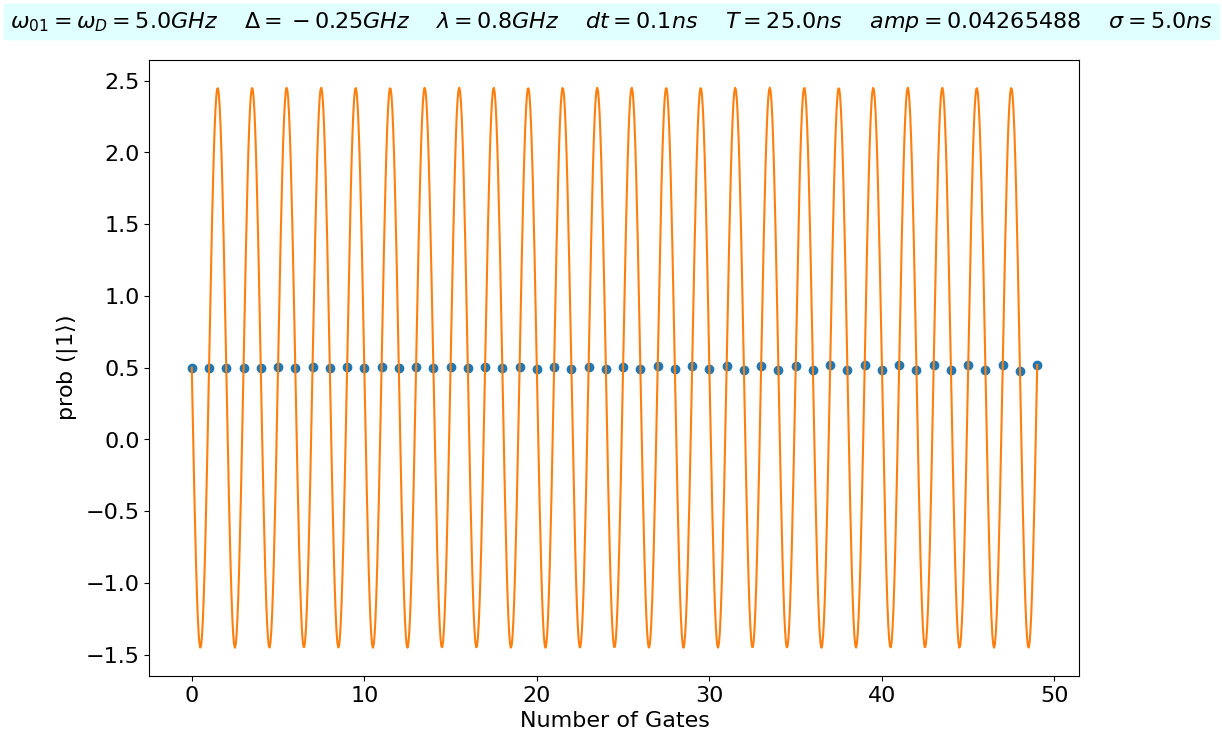

In [14]:
plt.close()
fig = plt.figure(figsize = (12,8))
plt.scatter(rep_range, [psi.probabilities()[1] for psi in solutions_g2], label = "Fine Amplitude exp")
# plt.scatter(rep_range, [psi.probabilities()[1] for psi in solutions_g], c='k', label = "Fine Amplitude exp")
plt.plot(np.linspace(0,rep_range[-1],1000), fit_func(np.linspace(0,rep_range[-1],1000), *popt2), label = "Fit", c='tab:orange')

# plt.ylim(-0.12, 1.12)
plt.xlabel("Number of Gates")
plt.ylabel(r"prob $(|1\rangle)$")

fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}} = \omega_D = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$T = {T} ns$    "
        + f"$amp = {amp}$    "
        + f"$\sigma = {sigma * dt} ns$"
    ),
    backgroundcolor="lightcyan",
    fontsize=16,
    horizontalalignment="center",
);

In [15]:
d_theta2 = popt2[2]
scale2 = np.pi/(np.pi + d_theta2)
new_amp2 = new_amp*scale2
print(new_amp2, scale2)

0.04230889744455814 0.9999355188626203
